# Soft Margin支持向量机

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets

In [37]:
sess = tf.Session()

iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

train_indices = np.random.choice(
    len(x_vals), size=round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

batch_size = 100
x_data = tf.placeholder(tf.float32, shape=[None, 2])
y_data = tf.placeholder(tf.float32, shape=[None, 1])
A = tf.Variable(tf.random_normal([2, 1]))
b = tf.Variable(tf.random_normal([1, 1]))

model_output = tf.subtract(tf.matmul(x_data, A), b)
l2_normal = tf.reduce_sum(tf.square(A))
alpha = tf.constant([0.1])
classification_term = tf.reduce_mean(
    tf.maximum(0., tf.subtract(1., tf.multiply(y_data, model_output))))
loss = tf.add(classification_term, tf.multiply(alpha, l2_normal))

prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_data), tf.float32))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

sess.run(tf.global_variables_initializer())

loss_vec = []
train_acc = []
test_acc = []
for i in range(500):
    rand_index = np.random.choice(
        len(x_vals_train), size=batch_size)  #,replace=False)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_data: rand_y})
    loss_vec.append(temp_loss)

    temp_train_acc = sess.run(
        accuracy,
        feed_dict={
            x_data: x_vals_train,
            y_data: np.transpose([y_vals_train])
        })
    train_acc.append(temp_train_acc)

    temp_test_acc = sess.run(
        accuracy,
        feed_dict={
            x_data: x_vals_test,
            y_data: np.transpose([y_vals_test])
        })
    test_acc.append(temp_test_acc)

    if (i + 1) % 100 == 0:
        print(temp_loss)

[0.3949479]
[0.43843853]
[0.38626552]
[0.46442437]
[0.42623866]


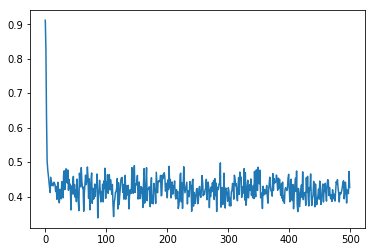

In [38]:
plt.plot(loss_vec)
plt.show()

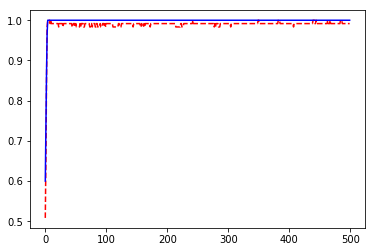

In [39]:
plt.plot(train_acc, 'r--', label = 'Train')
plt.plot(test_acc, 'b-', label = 'Test')
plt.show()

# 2.核函数的应用（高斯核）（模拟数据）

In [207]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

In [208]:
[x_vals , y_vals] = datasets.make_circles(n_samples=500, factor=0.5, noise = 0.1)
y_vals = np.array([1 if y == 1 else -1 for y in y_vals])
class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == 1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == 1]
class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == -1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == -1]


In [209]:
batch_size = 350
x_data = tf.placeholder(tf.float32, shape = [None, 2])
y_data = tf.placeholder(tf.float32, shape = [None, 1])
prediction_grid = tf.placeholder(tf.float32, shape = [None, 2])
b = tf.Variable(tf.random_normal([1, batch_size]))

In [210]:
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1, 1])
sq_dists = tf.add(tf.subtract(dist, 2.*tf.matmul(x_data, tf.transpose(x_data))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

In [211]:
#help(tf.reduce_sum)


In [220]:
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_data_cross = tf.matmul(y_data, tf.transpose(y_data))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_data_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

In [221]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])
pred_sq_dist = tf.add(tf.subtract(rA, 2.*tf.matmul(x_data, tf.transpose(prediction_grid))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_data), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_data)), tf.float32))

In [222]:
train_step = tf.train.GradientDescentOptimizer(0.002).minimize(loss)

sess.run(tf.global_variables_initializer())

In [223]:
loss_vec = []
batch_accuracy = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size = batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data:rand_x, y_data:rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_data:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_data:rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%100 == 0:
        print(temp_loss)

128.53162
88.82039
31.527048
2.410715
-5.466257
-9.512922
-10.094875
-11.270525
-12.337929
-11.196873
-11.449673
-12.647123
-12.253086
-12.048579
-12.073031


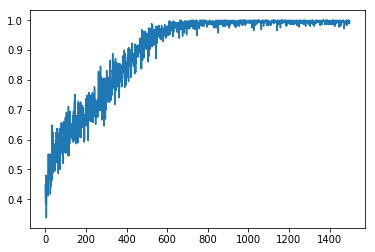

In [224]:
plt.plot(batch_accuracy)
plt.show()

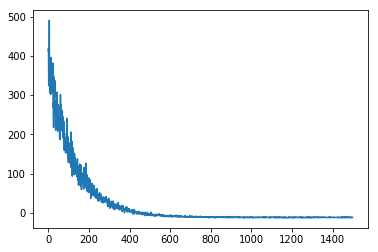

In [225]:
plt.plot(loss_vec)
plt.show()

In [226]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data:rand_x, y_data:rand_y, prediction_grid:grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

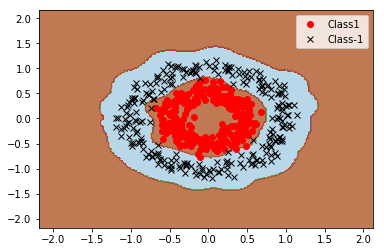

In [227]:
plt.contourf(xx, yy, grid_predictions, cmap = plt.cm.Paired, alpha = .8)



plt.plot(class1_x, class1_y, 'ro', label = 'Class1')
plt.plot(class2_x, class2_y, 'kx', label = 'Class-1')
plt.legend()
plt.show()

# 3.核函数的应用（高斯核）（Iris数据）